In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
df = pd.read_csv('data/news_cleaned.csv')
df.head()

,MatchDateTime,Station,Snippet,Tokens
0,2017-01-31 05:53:28,BBCNEWS,beena part to do. the airline industry has not...,"['beena', 'part', 'airline', 'industry', 'part..."
1,2017-01-18 19:21:01,BBCNEWS,"it's beaten it by about 0.1, 0.12 degrees cels...","['beaten', '01', '012', 'degrees', 'celsius', ..."
2,2017-01-05 21:48:46,BBCNEWS,"contact more than expected, how. your co nta c...","['contact', 'expected', 'co', 'nta', 'ct', 'le..."
3,2017-01-05 21:13:33,BBCNEWS,"where every time a marketplace is closed down,...","['every', 'time', 'marketplace', 'closed', 'an..."
4,2017-01-11 03:11:51,BBCNEWS,"applause climate change, a controversial issue...","['applause', 'climate', 'change', 'controversi..."


In [ ]:
# Remove climate bi-gram phrases
climate_grams = ["climate change", "global warming", "climate crisis", "greenhouse gas", "greenhouse gases", "carbon tax"]


<Axes: xlabel='snippets', ylabel='count'>

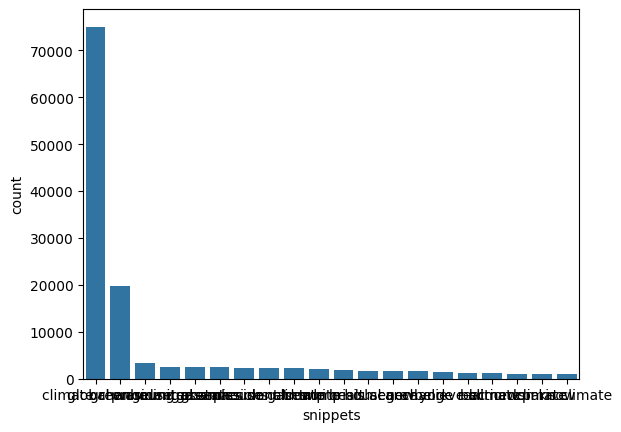

In [18]:
def get_top_n_ngram(corpus: pd.Series, n_phrases: int=10, ngram_min: int=2, ngram_max: int=2, stopwords: bool=True) -> pd.DataFrame:
    """
    Finds most common n-gram phrases in a given corpus and plot its distribution.
    :param corpus: pd.Series, text column
    :param n_phrases: int, number of n-gram phrases to return
    :param ngram_min: int, lower n-gram range boundary
    :param ngram_max: int, upper n-gram range boundary
    :param stopwords: bool, toggle stop word removal
    :return: pd.DataFrame of n-grams and their respective counts
    """
    # Check if n-grams should include stop words
    if stopwords:
        stopwords = 'english'
    else:
        stopwords = None

    try: 
        vec = CountVectorizer(ngram_range=(ngram_min, ngram_max), stop_words=stopwords).fit(corpus)

        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

    except ValueError:
        print("Invalid input")
    
    return pd.DataFrame(words_freq[:n_phrases], columns=['snippets', 'count'])


def plot_ngram_dist(df: pd.DataFrame) -> sns.histplot:
    """ 
    Plot the n-gram distribution.
    :param df: pd.DataFrame, dataframe of climate news snippets.
    :return: sns.histplot
    """
    return sns.barplot(df, x='snippets', y='count', legend=False)

phrase_df = get_top_n_ngram(corpus=df['Snippet'], n_phrases=20, ngram_min=2, ngram_max=2)
plot_ngram_dist(phrase_df)

In [14]:
phrase_df

,snippets,count
0,climate change,75024
1,of the,20464
2,global warming,19862
3,in the,16455
4,on the,9756
5,going to,9166
6,on climate,9159
7,to the,8730
8,change and,8432
9,of climate,8040
